In [1]:
import torch
from torch import nn
import torchvision.datasets as datasets
from torchvision.transforms import Compose
from torchvision import transforms
from torch.utils.data import DataLoader
from fastbound.bound_propagation import ibp_propagation
from models.SegRNN.Model import Model as SegRNN
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import time
from auto_LiRPA import BoundedModule, BoundedTensor
from auto_LiRPA.perturbations import PerturbationLpNorm

In [2]:
class MLP(nn.Module):
    def __init__(self, depth=8, width=256, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, width),
            nn.ReLU(),
            *[nn.Sequential(nn.Linear(width, width), nn.ReLU()) for _ in range(depth)],
            nn.Linear(width, 10)
        )
        
    def forward(self, x):
        return self.model(x)
    
    def forward_bounds(self, x_lower, x_upper):
        return ibp_propagation(x_lower, x_upper, self.model)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist_trainset = datasets.MNIST(root='./mnist_data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./mnist_data', train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=256, shuffle=False)

In [4]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss_robust = F.cross_entropy(y_pred, y)
        loss_robust.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Epoch {epoch}, Iteration {i}, Loss {loss_robust.item()}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            _, predicted = torch.max(y_pred.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    print(f"Epoch {epoch}, Accuracy {correct / total}")

Epoch 0, Iteration 0, Loss 2.304074287414551
Epoch 0, Iteration 100, Loss 0.9683399796485901
Epoch 0, Iteration 200, Loss 0.35621359944343567
Epoch 0, Accuracy 0.8846
Epoch 1, Iteration 0, Loss 0.33531180024147034
Epoch 1, Iteration 100, Loss 0.23624613881111145
Epoch 1, Iteration 200, Loss 0.1772335171699524
Epoch 1, Accuracy 0.921
Epoch 2, Iteration 0, Loss 0.3075789213180542
Epoch 2, Iteration 100, Loss 0.179481640458107
Epoch 2, Iteration 200, Loss 0.14583656191825867
Epoch 2, Accuracy 0.943


In [5]:
for x, _ in train_loader:
    x= x.to(device)
    break

In [6]:
epsilon = 0.5
x_lower, x_upper = x - epsilon, x + epsilon

norm = float("inf")

ptb = PerturbationLpNorm(norm=norm, eps=epsilon)
bounded_input = BoundedTensor(x, ptb)

In [7]:
widths = [16, 32, 64, 128, 256, 512]
depths = [2, 4, 8, 16, 32, 64, 128]

In [8]:
def metrics_for_fastbound():
    times = torch.zeros(len(widths), len(depths))
    mem = torch.zeros(len(widths), len(depths))
    initial_memory = torch.cuda.memory_allocated() / 1e9
    for w, width in enumerate(widths):
        for d, depth in enumerate(depths):
            model = MLP(width=width, depth=depth).to(device)
            start = time.time()
            for _ in range(100):
                y_lower, y_upper = model.forward_bounds(x_lower, x_upper)
            end = time.time()
            times[w, d] = (end - start) / 100
            mem[w, d] = torch.cuda.memory_allocated() / 1e9
    mem -= initial_memory
    return times, mem
times, mem = metrics_for_fastbound()

In [9]:
def metrics_for_auto_lirpa():
    times_auto = torch.zeros(len(widths), len(depths))
    mem_auto = torch.zeros(len(widths), len(depths))
    initial_memory = torch.cuda.memory_allocated() / 1e9
    for w, width in enumerate(widths):
        for d, depth in enumerate(depths):
            model = MLP(width=width, depth=depth).to(device)
            lirpa_model = BoundedModule(model, torch.empty_like(x)).to(device)
            
            start = time.time()
            for _ in range(100):
                y_lower_auto, y_upper_auto = lirpa_model.compute_bounds(x=(bounded_input), method='IBP')
            end = time.time()
            times_auto[w, d] = (end - start) / 100
            mem_auto[w, d] = torch.cuda.memory_allocated() / 1e9
    mem_auto -= initial_memory
    return times_auto, mem_auto
times_auto, mem_auto = metrics_for_auto_lirpa()

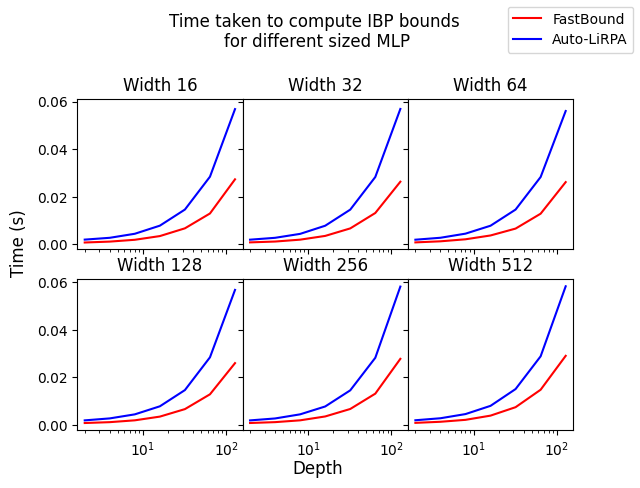

In [10]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0.2)
fig.suptitle('Time taken to compute IBP bounds \nfor different sized MLP')
fig.subplots_adjust(top=0.8)
for i, ax in enumerate(axs.flat):
    ax.plot(depths, times[i, :], label='FastBound', color='red')
    ax.plot(depths, times_auto[i, :], label='Auto-LiRPA', color='blue')
    ax.set_title(f'Width {widths[i]}')
fig.supylabel('Time (s)')
fig.supxlabel('Depth')
fig.legend(['FastBound', 'Auto-LiRPA'], loc='upper right')
plt.xscale('log')
plt.show()

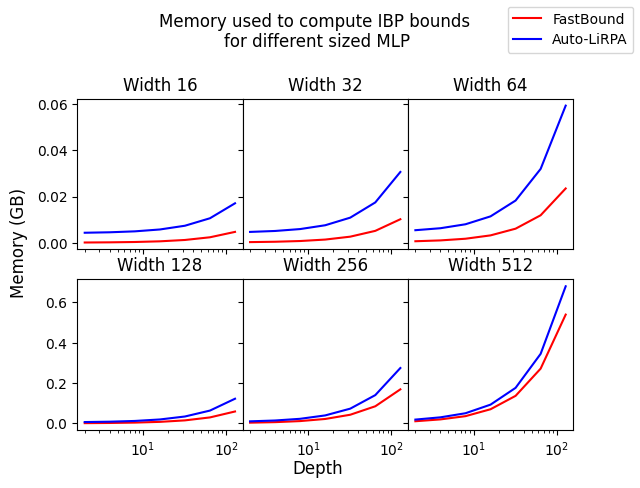

In [11]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey='row')
fig.subplots_adjust(wspace=0, hspace=0.2)
fig.suptitle('Memory used to compute IBP bounds \nfor different sized MLP')
fig.subplots_adjust(top=0.8)
for i, ax in enumerate(axs.flat):
    ax.plot(depths, mem[i, :], label='FastBound', color='red')
    ax.plot(depths, mem_auto[i, :], label='Auto-LiRPA', color='blue')
    ax.set_title(f'Width {widths[i]}')
fig.supylabel('Memory (GB)')
fig.supxlabel('Depth')
fig.legend(['FastBound', 'Auto-LiRPA'], loc='upper right')
plt.xscale('log')
plt.show()